# Python Geospatial Fundamental: Geoprocessing and Analysis

* * * 

<div class="alert alert-success">  
    
### Learning Objectives 
    
* Apply more advanced Python libraries for interactive visualization.
* Choose domain-specific spatial datasets to create your own maps.
</div>

### Sections
1. [Mapping and Spatial Analysis (cont'd)](#section1)
2. [Interactive Visualization](#section2)
3. [API, Vector and Raster Data Sources](#section3)
4. [Create Your Own Map](#section4)

<a id='section1'></a>

# 1. Mapping and Spatial Analysis (cont'd)

## Spatial Join

A **spatial join**, is the process by which we can leverage the spatial relationships between distinct datasets to merge their information into a new, synthetic dataset. This operation can be thought as the spatial equivalent of an **attribute join**, in which multiple tabular datasets can be merged by aligning matching values in a common column that they both contain. If you've done data wrangling in Python with `pandas`, you've probably performed an attribute join at some point.

We'll start by developing an understanding of this operation using census tract data.

In [1]:
! pip install mapclassify

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import mapclassify

%matplotlib inline  

In [3]:
# import school data
alameda_school = gpd.read_file('../data/alameda_school.shp')

# import census tract data
tracts_gdf = gpd.read_file("zip://../data/Census/Tracts/cb_2018_06_tract_500k.zip")

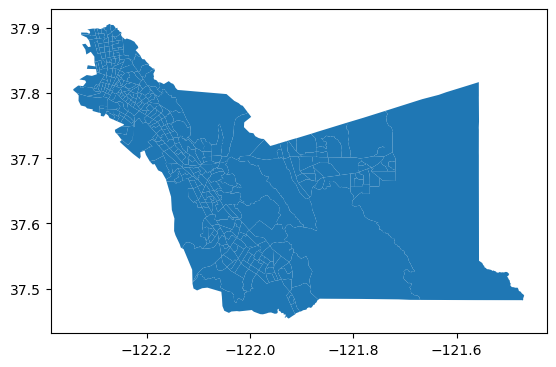

In [4]:
# select the tracts within Alameda county
alameda_tract = tracts_gdf[tracts_gdf['COUNTYFP'] == '001']
alameda_tract.plot()
plt.show()

In [5]:
# convert crs to that of Alameda schools
alameda_tract = alameda_tract.to_crs("epsg:3857")

In [6]:
# check if the crs' are the same
print(f'Alameda school CRS: {alameda_school.crs}')
print(f'Alameda tract CRS: {alameda_tract.crs}')

Alameda school CRS: EPSG:3857
Alameda tract CRS: epsg:3857


💡 **Tip**: Alternatively, we can use the following code to convert crs without having to type out EPSG code.

```python
alameda_school = alameda_school.to_crs(tracts_acs_gdf_ac.crs)
```

We're ready to combine the datasets in an analysis. In this case, we want to get data from the Census tract within which each school is located. We'll use the spatial join function `gpd.sjoin`. 

In [7]:
# take a look at the documentation
help(gpd.sjoin)

Help on function sjoin in module geopandas.tools.sjoin:

sjoin(left_df, right_df, how='inner', predicate='intersects', lsuffix='left', rsuffix='right', **kwargs)
    Spatial join of two GeoDataFrames.
    
    See the User Guide page :doc:`../../user_guide/mergingdata` for details.
    
    
    Parameters
    ----------
    left_df, right_df : GeoDataFrames
    how : string, default 'inner'
        The type of join:
    
        * 'left': use keys from left_df; retain only left_df geometry column
        * 'right': use keys from right_df; retain only right_df geometry column
        * 'inner': use intersection of keys from both dfs; retain only
          left_df geometry column
    predicate : string, default 'intersects'
        Binary predicate. Valid values are determined by the spatial index used.
        You can check the valid values in left_df or right_df as
        ``left_df.sindex.valid_query_predicates`` or
        ``right_df.sindex.valid_query_predicates``
        Replaces 

The key arguments to consider are:

- The two GeoDataFrames (**`left_df`** and **`right_df`**);
- The type of join to run (**`how`**), which can take the values `left`, `right`, or `inner`;
- The spatial relationship query to use (**`op`**).

A couple things to note:

- By default, `sjoin` is an inner join. It keeps the data from both GeoDataFrames only where the locations spatially intersect.
- By default, `sjoin` maintains the geometry of first geodataframe input to the operation. 

🔔 **Questions**: 

1. Which GeoDataFrame are we joining onto which (i.e. which one is getting the other one's data added to it)?
2. What happened to 'outer' as a join type?
3. Thus, in our operation, which GeoDataFrame should be the `left_df`, which should be the `right_df`, and `how` do we want our join to run?

In [8]:
schools_jointracts = gpd.sjoin(left_df = alameda_school,
                               right_df = alameda_tract,
                               how ='left')

In [9]:
schools_jointracts.head()

,OBJECTID,X,Y,Site,Address,City,State,Type,API,Org,...,index_right,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER
0,1,-122.238759,37.744765,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public,...,1547,06,001,428302,1400000US06001428302,06001428302,4283.02,CT,2234425,474770
1,2,-122.251853,37.739004,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public,...,1547,06,001,428302,1400000US06001428302,06001428302,4283.02,CT,2234425,474770
2,3,-122.258912,37.762062,Donald D. Lum Elementary,1801 Sandcreek Way,Alameda,CA,ES,853,Public,...,1432,06,001,428500,1400000US06001428500,06001428500,4285,CT,624197,383522
3,4,-122.234844,37.765247,Edison Elementary,2700 Buena Vista Ave,Alameda,CA,ES,927,Public,...,1430,06,001,427100,1400000US06001427100,06001427100,4271,CT,1025446,168187
4,5,-122.238076,37.753962,Frank Otis Elementary,3010 Fillmore St,Alameda,CA,ES,894,Public,...,2470,06,001,428200,1400000US06001428200,06001428200,4282,CT,1362067,804736


In [10]:
schools_jointracts.columns

Index(['OBJECTID', 'X', 'Y', 'Site', 'Address', 'City', 'State', 'Type', 'API',
       'Org', 'GlobalID', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER'],
      dtype='object')

---
### 🥊 Challenge: Confidence Checks

As always, we want to perform a confidence check on our intermediate result before we rush ahead.

One way to do that is to introspect the structure of the result object a bit.

1. What type of object should that have given us?
2. What should the dimensions of that object be, and why?
3. If we wanted a visual check of our results (i.e. a plot or map), what could we do?

---

In [11]:
# YOUR CODE HERE


<details><summary><a>Solution</a></summary>
    
```python
print(type(schools_jointracts))
print(schools_jointracts.shape)

ax = schools_jointracts.plot(color='white',
                            edgecolor='black',
                            figsize=(18, 18));
schools_jointracts.iloc[:16].plot(column='GEOID', ax=ax, legend=True);
```
</details>

## Attribute Join

As we saw in the `head` of that dataset, there are no Census attributes in this dataset.

In order to map the ACS data we need to associate it with the tracts. We will do that by joining the columns from `acs5_df_ac` to the columns of `schools_jointracts` using a common column as the key for matching rows. This process is called an **attribute join**. There are several ways we can go about performing this join.

💡 **Tip**: You can read more about merging in `geopandas` [here](http://geopandas.org/mergingdata.html#attribute-joins).

In [12]:
# Read in the ACS5 data for CA into a pandas DataFrame.
# Note: We force the FIPS_11_digit to be read in as a string to preserve any leading zeroes.
acs5_df = pd.read_csv("../data/Census/ACS5yr/census_variables_CA.csv", dtype={'FIPS_11_digit': str})
acs5_df.head()

,NAME,c_race,c_white,c_black,c_asian,c_latinx,c_race_moe,c_white_moe,c_black_moe,c_asian_moe,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,"Census Tract 4012, Alameda County, California",2456,1287,476,259,283,213,191,116,124,...,0.814951,0.103350,0.058415,0.010212,0.013072,0.551370,0.064384,0.189041,0.083562,0.058219
1,"Census Tract 4013, Alameda County, California",3983,845,1348,827,796,680,186,411,283,...,0.611865,0.280040,0.063348,0.022624,0.022122,0.341153,0.108993,0.391496,0.018084,0.104594
2,"Census Tract 4014, Alameda County, California",4340,713,1902,593,981,644,314,440,198,...,0.807683,0.163739,0.017803,0.006325,0.004451,0.470846,0.021317,0.255799,0.116614,0.102194
3,"Census Tract 4015, Alameda County, California",2080,563,1064,215,190,369,222,283,116,...,0.841346,0.101442,0.053846,0.003365,0.000000,0.502037,0.090631,0.230143,0.047862,0.017312
4,"Census Tract 4016, Alameda County, California",1889,324,960,247,274,400,135,376,164,...,0.830645,0.079570,0.082258,0.002151,0.005376,0.570481,0.122720,0.177446,0.063018,0.000000


**Brief summary of the data**:

Below is a table of the variables in this table. They were combined from 
different ACS 5 year tables.

A few things to note:
- Variables that start with `c_` are counts.
- Variables that start with `med_` are medians.
- Variables that end in `_moe` are margin of error estimates.
- Variables that start with `_p` are proportions calcuated from the counts divided by the table denominator (the total count for whom that variable was assessed).


| Variable        | Description                                     |
|-----------------|-------------------------------------------------|
|`c_race`         |Total population                                 
|`c_white`        |Total white non-Latinx
| `c_black`       | Total black and African American non-Latinx
| `c_asian`       | Total Asian non-Latinx
| `c_latinx`      | Total Latinx
| `state_fips`    | State level FIPS code
| `county_fips`   | County level FIPS code
| `tract_fips`    |Tracts level FIPS code
| `med_rent`      |Median rent
| `med_hhinc`     |Median household income
| `c_tenants`     |Total tenants
| `c_owners`      |Total owners
| `c_renters`     |Total renters
| `c_movers`      |Total number of people who moved
| `c_stay`        |Total number of people who stayed
| `c_movelocal`   |Number of people who moved locally
| `c_movecounty`  |Number of people who moved counties
| `c_movestate`   | Number of people who moved states
| `c_moveabroad`  |Number of people who moved abroad
| `c_commute`     |Total number of commuters
| `c_car`         | Number of commuters who use a car
| `c_carpool`     | Number of commuters who carpool
| `c_transit`     |Number of commuters who use public transit
| `c_bike`        |Number of commuters who bike
| `c_walk`        |Number of commuters who bike
| `year`          | ACS data year
| `FIPS_11_digit` | 11-digit FIPS code

We're going to drop all of our `moe` columns by identifying all of those that end with `_moe`. We can do that in two steps, first by using `filter` to identify columns that contain the string `_moe`.

In [13]:
moe_cols = acs5_df.filter(like='_moe', axis=1).columns
moe_cols

Index(['c_race_moe', 'c_white_moe', 'c_black_moe', 'c_asian_moe',
       'c_latinx_moe', 'med_rent_moe', 'med_hhinc_moe', 'c_tenants_moe',
       'c_owners_moe', 'c_renters_moe', 'c_movers_moe', 'c_stay_moe',
       'c_movelocal_moe', 'c_movecounty_moe', 'c_movestate_moe',
       'c_moveabroad_moe', 'c_commute_moe', 'c_car_moe', 'c_carpool_moe',
       'c_transit_moe', 'c_bike_moe', 'c_walk_moe'],
      dtype='object')

In [14]:
acs5_df.drop(moe_cols, axis=1, inplace=True)

And lastly, let's grab only the rows for year 2018 and county FIPS code 1 (Alameda County).

In [15]:
acs5_df_ac = acs5_df[(acs5_df['year'] == 2018) & (acs5_df['county_fips'] == 1)]

Let's take a look at the common column in both our DataFrames.

In [16]:
acs5_df_ac['FIPS_11_digit'].head()

8323    06001441501
8324    06001404700
8325    06001442500
8326    06001450300
8327    06001450607
Name: FIPS_11_digit, dtype: object

In [17]:
schools_jointracts['GEOID'].head()

0    06001428302
1    06001428302
2    06001428500
3    06001427100
4    06001428200
Name: GEOID, dtype: object

Note that they are not named the same thing, but we just need to know that they contain the same information. Also note that they are not in the same order. 
        
That's not only okay... that's the point! If they were in the same order already then we could just join them side by side, without having Python find and line up the matching rows from each.

Let's do a `left` join to keep all of the Census tracts in Alameda County with schools and only the ACS data for those tracts.

In [18]:
# Left join keeps all tracts and the ACS data for those tracts
schools_jointracts = schools_jointracts.merge(acs5_df_ac,
                                        left_on='GEOID',
                                        right_on='FIPS_11_digit',
                                        how='left')
schools_jointracts.head(2)

,OBJECTID,X,Y,Site,Address,City,State,Type,API,Org,...,p_stay,p_movelocal,p_movecounty,p_movestate,p_moveabroad,p_car,p_carpool,p_transit,p_bike,p_walk
0,1,-122.238759,37.744765,Amelia Earhart Elementary,400 Packet Landing Rd,Alameda,CA,ES,933,Public,...,0.901694,0.05312,0.013314,0.023534,0.008338,0.680745,0.07765,0.107293,0.004722,0.01915
1,2,-122.251853,37.739004,Bay Farm Elementary,200 Aughinbaugh Way,Alameda,CA,ES,932,Public,...,0.901694,0.05312,0.013314,0.023534,0.008338,0.680745,0.07765,0.107293,0.004722,0.01915


In [19]:
schools_jointracts.columns

Index(['OBJECTID', 'X', 'Y', 'Site', 'Address', 'City', 'State', 'Type', 'API',
       'Org', 'GlobalID', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'AFFGEOID', 'GEOID', 'NAME_x', 'LSAD', 'ALAND', 'AWATER',
       'NAME_y', 'c_race', 'c_white', 'c_black', 'c_asian', 'c_latinx',
       'state_fips', 'county_fips', 'tract_fips', 'med_rent', 'med_hhinc',
       'c_tenants', 'c_owners', 'c_renters', 'c_movers', 'c_stay',
       'c_movelocal', 'c_movecounty', 'c_movestate', 'c_moveabroad',
       'c_commute', 'c_car', 'c_carpool', 'c_transit', 'c_bike', 'c_walk',
       'year', 'FIPS_11_digit', 'p_white', 'p_black', 'p_asian', 'p_latinx',
       'p_owners', 'p_renters', 'p_stay', 'p_movelocal', 'p_movecounty',
       'p_movestate', 'p_moveabroad', 'p_car', 'p_carpool', 'p_transit',
       'p_bike', 'p_walk'],
      dtype='object')

Let's save out our merged data so we can use it in the final notebook.

In [20]:
schools_jointracts_dg = schools_jointracts.to_crs("EPSG:4326")
schools_jointracts_dg.to_file('../data/schools_jointracts.json', driver='GeoJSON')

Now that we have all the variables joined, let's take a look at the relationship between variables (e.g., median household income in a Census tract and a school's Acamdemic Performance Index (API)) by a scatter plot.

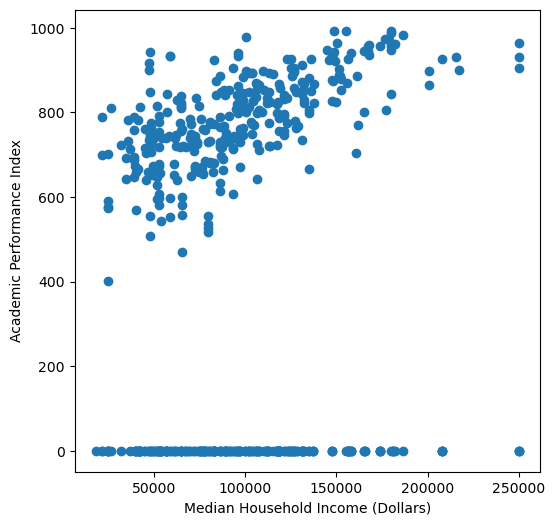

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(schools_jointracts.med_hhinc, schools_jointracts.API)
ax.set_xlabel('Median Household Income (Dollars)')
ax.set_ylabel('Academic Performance Index');

Just as we suspected based on our overlay map, there's a pretty obvious, strong, and positive correlation between median household income in a school's tract and the school's API.

## Aggregation

We just saw that a spatial join in one way to leverage the spatial relationship between two datasets in order to create a new dataset,

An **aggregation** is another way we can generate new data from this relationship. In this case, for each feature in one dataset we find all the features in another dataset that satisfy our chosen spatial relationship query with it (e.g. within, intersects), then aggregate them using some summary function (e.g. count, mean).

Let's perform the `groupby` operation.

When aggregating by count, we'll get the counts for every column, which will be the same. So, we'll just select the `GEOID` and `Site` columns at the end.

In [22]:
schools_countsbytract = schools_jointracts.groupby('GEOID', as_index=False).count()[['GEOID','Site']]
print(f"Counts, rows and columns: {schools_countsbytract.shape}")

# Take a look at the data
schools_countsbytract.head()

Counts, rows and columns: (263, 2)


,GEOID,Site
0,06001400100,1
1,06001400200,1
2,06001400400,2
3,06001400500,1
4,06001400700,2


The above `groupby` and `count` operations give us the counts we wanted.

- We have 263 (of 361) Census tracts that contain at least one school.
- We have the number of schools within each of those tracts.

But, the output of `groupby` is a plain DataFrame, and not a GeoDataFrame.

If we want a GeoDataFrame, then we have two options:

1. We could join the `groupby` output to `alameda_tract` by the attribute `GEOID`.
2. We could start over, using the GeoDataFrame `dissolve` method, which we can think of as a spatial `groupby`.

Since we already know how to do an attribute join, we'll do the `dissolve`.

First, let's run a new spatial join.

In [23]:
tracts_joinschools = gpd.sjoin(left_df = alameda_school,
                               right_df = alameda_tract,
                               how='right')

In [24]:
tracts_joinschools.head()

,index_left,OBJECTID,X,Y,Site,Address,City,State,Type,API,...,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,06,001,425101,1400000US06001425101,06001425101,4251.01,CT,590870,2045459,"POLYGON ((-13615953.904 4557173.533, -13614288..."
27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,06,001,428600,1400000US06001428600,06001428600,4286,CT,898967,1080420,"POLYGON ((-13612139.653 4546728.844, -13611979..."
28,544.0,545.0,-122.159604,37.724448,St. Leander,451 Davis Street,San Leandro,CA,K-8,0.0,...,06,001,432600,1400000US06001432600,06001432600,4326,CT,1673450,0,"POLYGON ((-13599624.671 4540836.105, -13598909..."
29,362.0,363.0,-122.146126,37.698206,Monroe Elementary,3750 Monterey Blvd,San Leandro,CA,ES,760.0,...,06,001,433200,1400000US06001433200,06001433200,4332,CT,3174901,0,"POLYGON ((-13599531.719 4538598.534, -13598298..."
29,369.0,370.0,-122.159787,37.708351,Lincoln High (Continuation),2600 Teagarden St,San Leandro,CA,ASAM,0.0,...,06,001,433200,1400000US06001433200,06001433200,4332,CT,3174901,0,"POLYGON ((-13599531.719 4538598.534, -13598298..."


Now, let's run the dissolve.

In [25]:
tracts_schoolcounts = tracts_joinschools[['GEOID', 'Site', 'geometry']].dissolve(by='GEOID', aggfunc='count')
print(f"Counts, rows and columns: {tracts_schoolcounts.shape}")

tracts_schoolcounts.head()

Counts, rows and columns: (360, 2)


,geometry,Site
GEOID,,
06001400100,"POLYGON ((-13608464.885 4563254.661, -13607913...",1
06001400200,"POLYGON ((-13609633.517 4557284.190, -13609498...",1
06001400300,"POLYGON ((-13610384.479 4556847.348, -13610127...",0
06001400400,"POLYGON ((-13610065.214 4557556.398, -13610034...",2
06001400500,"POLYGON ((-13610968.349 4557990.592, -13610857...",1


💡 **Tip**: 

- The `dissolve` operation requires a geometry column and a grouping column (in our case, `'GEOID'`). Any geometries within the **same group** will be dissolved if they have the same geometry or nested geometries. 
 
- The `aggfunc`, or aggregation function, of the dissolve operation will be applied to all numeric columns in the input geodataframe (unless the function is `count` in which case it will count rows).  

Check out the Geopandas documentation on [dissolve](https://geopandas.org/aggregation_with_dissolve.html?highlight=dissolve) for more information.

🔔 **Question**:

1. Above, we selected three columns from the input GeoDataFrame to create a subset as input to the dissolve operation. Why?
2. Why did we run a new spatial join? What would have happened if we had used the `schools_jointracts` object instead?
3. What explains the dimensions of the new object (361, 2)?

Because our `sjoin` plus `dissolve` pipeline outputs a GeoDataFrame, we can now map the school count by Census tract.

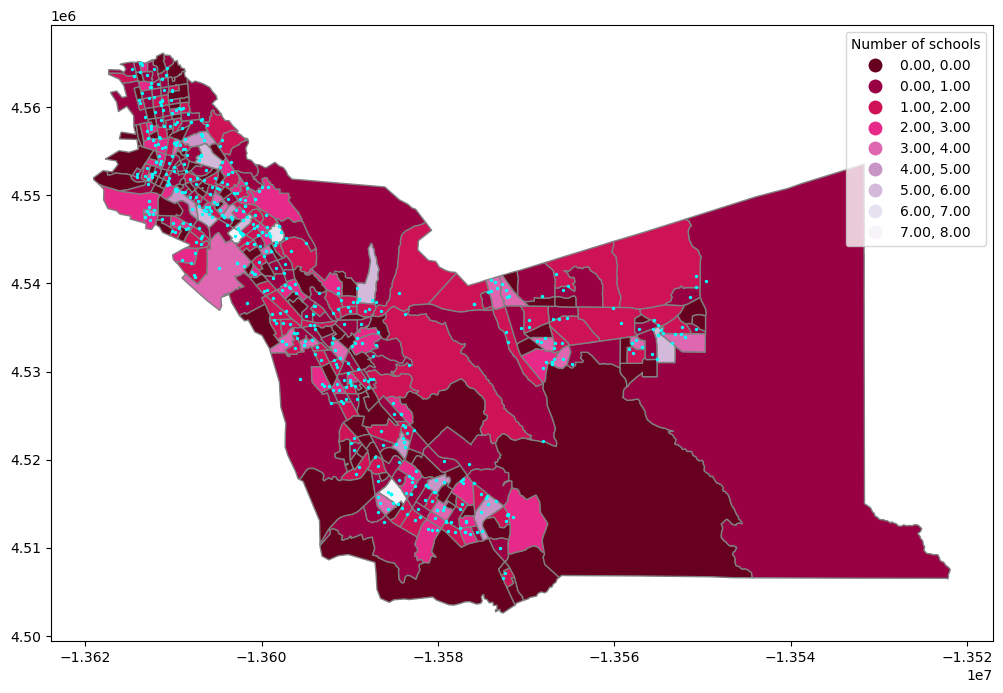

In [26]:
fig, ax = plt.subplots(figsize = (14, 8)) 

# Display the output of our spatial join
tracts_schoolcounts.plot(ax=ax,
                         column='Site', 
                         scheme="user_defined",
                         classification_kwds={'bins': list(range(9))},
                         cmap="PuRd_r",
                         edgecolor="grey",
                         legend=True, 
                         legend_kwds={'title': 'Number of schools'})
alameda_school.plot(ax=ax,
                 color='cyan',
                 markersize=2);

<a id='section2'></a>

# 2. 🎬 **Demo**:  Interactive Visualization

In addition to the static maps, we can visualize the spaital data on an interactive map. Here we use the `folium` library with `.geojson` layers for demonstration. 

In [27]:
! pip install folium

Defaulting to user installation because normal site-packages is not writeable


In [38]:
import folium

m = folium.Map(
        location = [37.6017, -121.7195], # we get the [lat, lon] of Alameda County [37.6017, -121.7195]
        tiles = "CartoDB positron",
        zoom_start = 10
        )

folium.GeoJson('../data/alameda_county.geojson', name = "county").add_to(m)
folium.GeoJson('../data/alameda_school.geojson', name = "school").add_to(m)
folium.GeoJson('../data/alameda_bike.geojson', name = "bike facility").add_to(m)

folium.LayerControl().add_to(m)

m

💡 **Tip**: In addition to the basic map, you can create all kinds of interactive maps. Check out the [documentation](https://python-visualization.github.io/folium/latest/). 

<a id='section3'></a>

# 3. 🎬 **Demo**: API, Vector and Raster Data Sources

So far, we've see spatial data in vector format. If you need to work with raster data, the `rasterio` Python library is an option. You can read its documentation [here](https://pypi.org/project/rasterio/). [Google Earth Engine Python API](https://dlab.berkeley.edu/news/mapping-time-series-satellite-images-google-earth-engine-api-1) is another powerful tool to explore planetary scale raster data. 

Some additional data sources for your mapping project: 

1. [Census Data](https://data.census.gov/) and [API](https://www.census.gov/data/developers/data-sets.html)
2. [California State Geoportal](https://gis.data.ca.gov/)
3. [MTC Open Data Portal](https://opendata.mtc.ca.gov/)
4. [The USGS National Data Viewer](https://www.usgs.gov/tools/national-map-viewer)
5. [The USGS Earth Explorer](https://earthexplorer.usgs.gov/)

<a id='section4'></a>

# 4. 🥊 Challenge: Create Your Own Map

Now it's the time for you to generate some custom maps for the topics of your interest using the data and tools introduced in this workshop. 

In [ ]:
# YOUR CODE HERE


<div class="alert alert-success">

## ❗ Key Points

* Spatial, attribute joins, and aggregation.
* Interactive mapping using `folium`.

</div>